In [1]:
import pickle

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve
)

from sklearn.model_selection import (
    cross_val_score, validation_curve, learning_curve, train_test_split, GridSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import sklearn.exceptions
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)

all_classifiers = (GaussianNB, LogisticRegression, RandomForestClassifier)
sns.set(font_scale=1)
pd.set_option('display.max_rows', 30)
%matplotlib inline

Load the raw data and look at the feature distribution

In [2]:
raw_data = pd.read_csv('../instructions/worker_accident_dataset.csv', dtype={'had_accident': 'bool'})

In [3]:
raw_data.groupby(['had_accident']).count()

,risk_score,gender,age,years_experience,role,company,state,hours_worked_per_week
had_accident,,,,,,,,
False,94616,94616,94616,94616,94616,94616,94616,94616
True,5384,5384,5384,5384,5384,5384,5384,5384


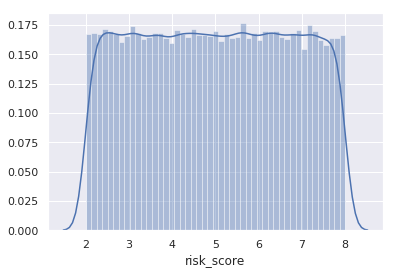

In [233]:
sns.distplot(raw_data['risk_score'])

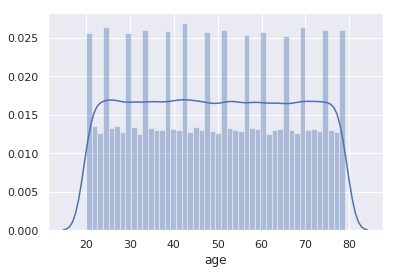

In [234]:
sns.distplot(raw_data['age'])

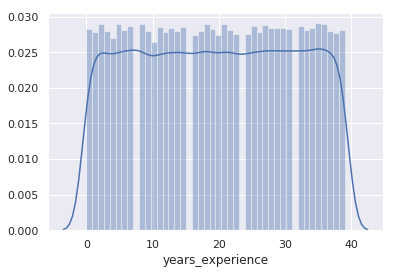

In [235]:
sns.distplot(raw_data['years_experience'])

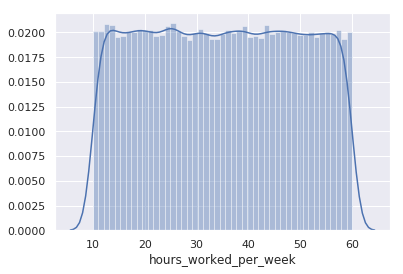

In [236]:
sns.distplot(raw_data['hours_worked_per_week'])

In [285]:
raw_data.head(10)

,risk_score,gender,age,years_experience,role,company,state,hours_worked_per_week,had_accident
0,5.736603,M,52.0,38.0,Employee,36,3.0,28.672870,False
1,5.944097,F,30.0,33.0,Employee,7,0.0,40.868965,False
2,5.308688,F,24.0,4.0,Employee,10,1.0,23.238966,False
3,3.169367,F,42.0,18.0,Manager,89,8.0,22.421832,False
4,4.211781,F,37.0,20.0,Manager,1,0.0,44.144834,False
5,5.597752,F,73.0,36.0,Employee,20,2.0,38.001743,False
6,4.435424,M,24.0,6.0,Employee,41,4.0,57.901800,False
7,7.775972,F,42.0,10.0,Employee,81,8.0,56.573606,True
8,7.318181,F,25.0,9.0,Employee,98,9.0,26.239097,False
9,7.274954,F,70.0,35.0,Employee,42,4.0,36.914861,False


# Analyze GradientBoostingClassifier

In [4]:
X = raw_data.drop('had_accident', axis=1)
y = raw_data['had_accident']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

## GB without numeric scaling

### Score on recall

In [26]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['risk_score', 'age', 'years_experience', 'hours_worked_per_week']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['gender', 'role', 'company', 'state']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', numeric_transformer, numeric_features),
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])

param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 500],
}

grid_gb = GridSearchCV(clf_gb, param_grid, cv=3, iid=False, scoring='recall')
grid_gb.fit(X_train, y_train)
print('Best score', grid_gb.best_score_)
print('Best params', grid_gb.best_params_)

Best score 0.029661885863861714
Best params {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 500}


In [27]:
y_pred = grid_gb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'--GradientBoostingClassifier--')
print(f'|{tp:^10}|{fp:^10}|')
print(f'|{fn:^10}|{tn:^10}|')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print()

--GradientBoostingClassifier--
|    66    |   835    |
|   2587   |  46512   |
Accuracy: 0.93156
Precision: 0.0732519422863485
Recall: 0.024877497173011683
F1: 0.037141249296567244



### Score on f1

In [29]:
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 500],
}

grid_gb = GridSearchCV(clf_gb, param_grid, cv=3, iid=False, scoring='f1')
grid_gb.fit(X_train, y_train)
print('Best score', grid_gb.best_score_)
print('Best params', grid_gb.best_params_)

/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted 

Best score 0.04449241781956018
Best params {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 500}


In [30]:
y_pred = grid_gb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'--GradientBoostingClassifier--')
print(f'|{tp:^10}|{fp:^10}|')
print(f'|{fn:^10}|{tn:^10}|')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print()

--GradientBoostingClassifier--
|    65    |   825    |
|   2588   |  46522   |
Accuracy: 0.93174
Precision: 0.07303370786516854
Recall: 0.024500565397663022
F1: 0.03669206886819079



## GB with fewer cat features

In [32]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['risk_score', 'age', 'years_experience', 'hours_worked_per_week', 'company', 'state']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['gender', 'role']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', numeric_transformer, numeric_features),
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])

param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 500],
}

grid_gb = GridSearchCV(clf_gb, param_grid, cv=3, iid=False, scoring='recall')
grid_gb.fit(X_train, y_train)
print('Best score', grid_gb.best_score_)
print('Best params', grid_gb.best_params_)

Best score 0.034786472217866286
Best params {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 500}


In [33]:
y_pred = grid_gb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'--GradientBoostingClassifier--')
print(f'|{tp:^10}|{fp:^10}|')
print(f'|{fn:^10}|{tn:^10}|')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print()

--GradientBoostingClassifier--
|    77    |   826    |
|   2576   |  46521   |
Accuracy: 0.93196
Precision: 0.08527131782945736
Recall: 0.029023746701846966
F1: 0.04330708661417323



### Validation curve

In [51]:
param_range = range(1, 2000, 100)
clf_gb = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(learning_rate=0.5))
    ]
)
train_score, val_score= validation_curve(
    clf_gb, X_train, y_train,
    'classifier__n_estimators', param_range, cv=2,
    scoring='recall'
)

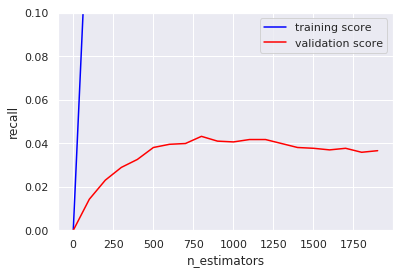

In [53]:
plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.ylim(0, 0.1)
plt.xlabel('n_estimators')
plt.ylabel('recall');

In [57]:
param_range = np.linspace(0.1, 2, 20)
clf_gb = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=800))
    ]
)
train_score_lr, val_score_lr = validation_curve(
    clf_gb, X_train, y_train,
    'classifier__learning_rate', param_range, cv=2,
    scoring='recall'
)

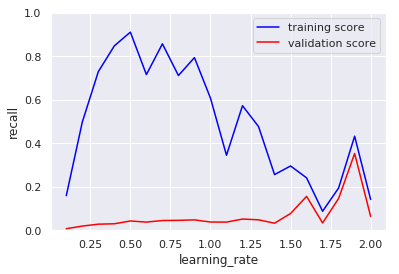

In [58]:
plt.plot(param_range, np.median(train_score_lr, 1), color='blue', label='training score')
plt.plot(param_range, np.median(val_score_lr, 1), color='red', label='validation score')
plt.legend()
plt.ylim(0, 1)
plt.xlabel('learning_rate')
plt.ylabel('recall');

## GB with all features

In [59]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['risk_score', 'age', 'years_experience', 'hours_worked_per_week']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['gender', 'role', 'company', 'state']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
#         ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])

param_grid = {
    'classifier__learning_rate': [1.5, 1.7, 1.9],
    'classifier__n_estimators': [500, 750, 1000],
}

grid_gb = GridSearchCV(clf_gb, param_grid, cv=3, iid=False, scoring='recall')
grid_gb.fit(X_train, y_train)
print('Best score', grid_gb.best_score_)
print('Best params', grid_gb.best_params_)

Best score 0.2130649811220612
Best params {'classifier__learning_rate': 1.9, 'classifier__n_estimators': 500}


In [60]:
y_pred = grid_gb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'--GradientBoostingClassifier--')
print(f'|{tp:^10}|{fp:^10}|')
print(f'|{fn:^10}|{tn:^10}|')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print()

--GradientBoostingClassifier--
|   821    |   4568   |
|   1832   |  42779   |
Accuracy: 0.872
Precision: 0.15234737428094267
Recall: 0.3094609875612514
F1: 0.2041780651579209



### Learning curve

In [ ]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['risk_score', 'age', 'years_experience', 'hours_worked_per_week']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['gender', 'role', 'company', 'state']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
#         ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier(learning_rate=1.9, n_estimators=800))])

train_sizes_gb, train_scores_gb, valid_scores_gb = learning_curve(
    clf_gb, X, y, cv=5, train_sizes=np.linspace(0.01, 1, 25)
)

In [ ]:
figsize = (800 / 72, 600 / 72)
figplacement = [0, 0, 1, 1 ]
    
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(figplacement)
ax.set_xlim(train_sizes_gb[0], train_sizes_gb[-1])
ax.set_ylim(0.8, 1.1)
ax.set_ylabel('score')
ax.set_xlabel('training size')

ax.plot(train_sizes_gb, np.mean(train_scores_gb, 1))
ax.plot(train_sizes_gb, np.mean(valid_scores_gb, 1))
ax.hlines(
    np.mean([train_scores_gb[-1], valid_scores_gb[-1]]), train_sizes_gb[0], train_sizes_gb[-1], 
    color='gray', linestyle='dashed'
)

# Other

In [335]:
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='saga'))])

clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])

X = raw_data.drop('had_accident', axis=1)
y = raw_data['had_accident']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

### GB without numeric scaling

In [336]:
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 500],
}

grid_gb = GridSearchCV(clf_gb, param_grid, cv=3, iid=False, scoring='recall')
grid_gb.fit(X_train, y_train)
print('Best score', grid_gb.best_score_)
print('Best params', grid_gb.best_params_)

Best score 0.0
Best params {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}


In [ ]:
y_pred = grid_gb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'--GradientBoostingClassifier--')
print(f'|{tp:^10}|{fp:^10}|')
print(f'|{fn:^10}|{tn:^10}|')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print()

--GradientBoostingClassifier--
|    0     |    0     |
|   2643   |  47357   |
Accuracy: 0.94714
Precision: 0.0
Recall: 0.0
F1: 0.0



/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### GB with numeric scaling

In [324]:
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 500],
}

grid_gb = GridSearchCV(clf_gb, param_grid, cv=3, iid=False, scoring='recall')
grid_gb.fit(X_train, y_train)
print('Best score', grid_gb.best_score_)
print('Best params', grid_gb.best_params_)

Best score 0.039358282461883276
Best params {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 500}


In [333]:
y_pred = grid_gb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'--GradientBoostingClassifier--')
print(f'|{tp:^10}|{fp:^10}|')
print(f'|{fn:^10}|{tn:^10}|')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print()

--GradientBoostingClassifier--
|   512    |   429    |
|   2172   |  46887   |
Accuracy: 0.94798
Precision: 0.5441020191285866
Recall: 0.19076005961251863
F1: 0.28248275862068967



In [ ]:
train_sizes_gb, train_scores_gb, valid_scores_gb = learning_curve(
    clf_gb, X, y, cv=5, train_sizes=np.linspace(0.01, 1, 25), scoring='precision'
)

/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

In [ ]:
figsize = (800 / 72, 600 / 72)
figplacement = [0, 0, 1, 1 ]
    
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(figplacement)
ax.set_xlim(train_sizes_gb[0], train_sizes_gb[-1])
ax.set_ylim(0, 1)
ax.set_ylabel('score')
ax.set_xlabel('training size')

ax.plot(train_sizes_gb, np.mean(train_scores_gb, 1))
ax.plot(train_sizes_gb, np.mean(valid_scores_gb, 1))
ax.hlines(
    np.mean([train_scores_gb[-1], valid_scores_gb[-1]]), train_sizes_gb[0], train_sizes_gb[-1], 
    color='gray', linestyle='dashed'
)

other models

In [317]:
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
}

grid_rf = GridSearchCV(clf_rf, param_grid, cv=3, iid=False, scoring='recall')
grid_rf.fit(X_train, y_train)
print('Best score', grid_rf.best_score_)
print('Best params', grid_rf.best_params_)

Best score 0.006944444444444444
Best params {'classifier__n_estimators': 10}


In [314]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__max_iter': [10, 100, 500],
}

grid_lr = GridSearchCV(clf_lr, param_grid, cv=3, iid=False, scoring='recall')
grid_lr.fit(X_train, y_train)
print('Best score', grid_lr.best_score_)
print('Best params', grid_lr.best_params_)

Best score 0.0
Best params {'classifier__C': 0.1, 'classifier__max_iter': 10}


In [293]:
print('RandomForestClassifier', grid_rf.score(X_test, y_test))
print('GradientBoostingClassifier', grid_gb.score(X_test, y_test))
print('LogisticRegression', grid_lr.score(X_test, y_test))

RandomForestClassifier 0.94704
GradientBoostingClassifier 0.94724
LogisticRegression 0.94724


In [318]:
for model_type in ('grid_rf', 'grid_lr', 'grid_gb'):
    y_pred = globals()[model_type].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f'--{model_type}--')
    print(f'|{tp:^10}|{fp:^10}|')
    print(f'|{fn:^10}|{tn:^10}|')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print()

--grid_rf--
|    5     |    78    |
|   2643   |  47274   |
Accuracy: 0.94558
Precision: 0.060240963855421686
Recall: 0.0018882175226586104
F1: 0.003661662394727206

--grid_lr--
|    0     |    0     |
|   2648   |  47352   |
Accuracy: 0.94704
Precision: 0.0
Recall: 0.0
F1: 0.0



/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


--grid_gb--
|   572    |   382    |
|   2076   |  46970   |
Accuracy: 0.95084
Precision: 0.59958071278826
Recall: 0.21601208459214502
F1: 0.3176013325930038



In [303]:
pd.concat([X_test, y_test], axis=1).groupby(['had_accident']).count()

,risk_score,gender,age,years_experience,role,company,state,hours_worked_per_week
had_accident,,,,,,,,
False,47362,47362,47362,47362,47362,47362,47362,47362
True,2638,2638,2638,2638,2638,2638,2638,2638


In [228]:
pickle.dump(grid_lr, open('../glow_ml/models/predict_accident.pkl', 'wb'))
pickle.dump(grid_gb, open('../glow_ml/models/predict_accident_gb.pkl', 'wb'))
pickle.dump(grid_rf, open('../glow_ml/models/predict_accident_rf.pkl', 'wb'))

More evaluation: validation curves

In [280]:
param_range = np.linspace(0.001, 100, 10)
train_score, val_score= validation_curve(
    clf_lr, X_train, y_train,
    'classifier__C', param_range, cv=2
)

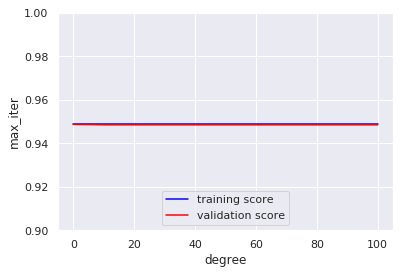

In [281]:
plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(val_score, 1), color='red', label='validation score')
# plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
# plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0.9, 1)
plt.xlabel('degree')
plt.ylabel('max_iter');

More evaluation: learning curves

In [222]:
train_sizes_gb, train_scores_gb, valid_scores_gb = learning_curve(
    clf_gb, X, y, cv=5, train_sizes=np.linspace(0.01, 1, 25)
)

In [224]:
train_sizes_rf, train_scores_rf, valid_scores_rf = learning_curve(
    clf_rf, X, y, cv=5, train_sizes=np.linspace(0.01, 1, 25)
)

In [226]:
train_sizes_lr, train_scores_lr, valid_scores_lr = learning_curve(
    clf_lr, X, y, cv=5, train_sizes=np.linspace(0.01, 1, 25)
)

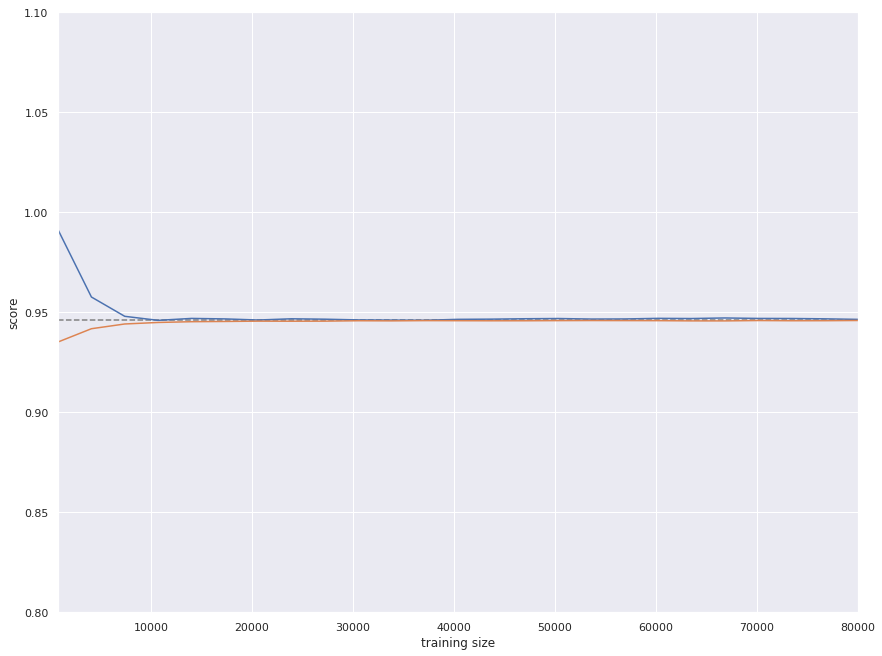

In [223]:
figsize = (800 / 72, 600 / 72)
figplacement = [0, 0, 1, 1 ]
    
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(figplacement)
ax.set_xlim(train_sizes_gb[0], train_sizes_gb[-1])
ax.set_ylim(0.8, 1.1)
ax.set_ylabel('score')
ax.set_xlabel('training size')

ax.plot(train_sizes_gb, np.mean(train_scores_gb, 1))
ax.plot(train_sizes_gb, np.mean(valid_scores_gb, 1))
ax.hlines(
    np.mean([train_scores_gb[-1], valid_scores_gb[-1]]), train_sizes_gb[0], train_sizes_gb[-1], 
    color='gray', linestyle='dashed'
)

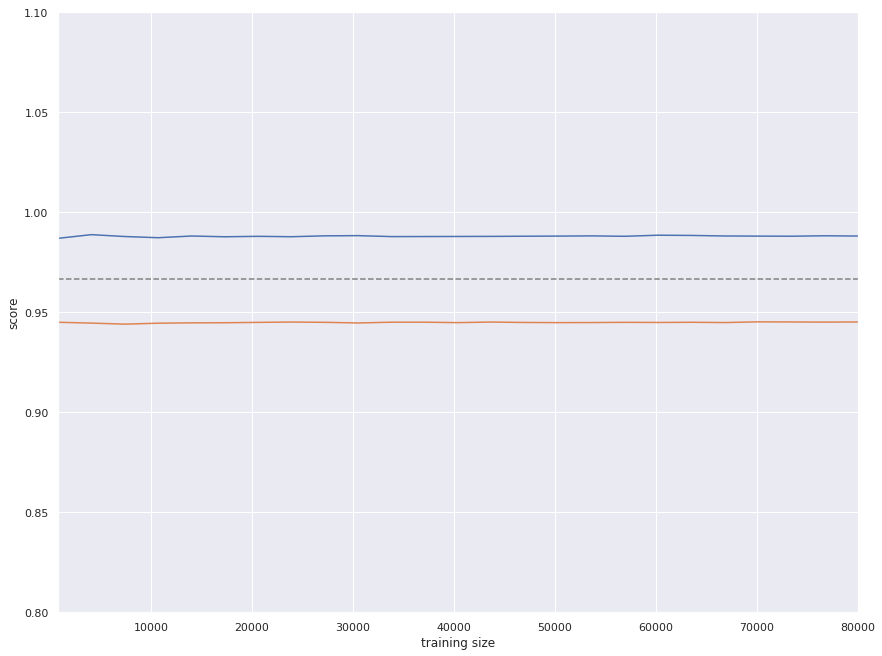

In [225]:
figsize = (800 / 72, 600 / 72)
figplacement = [0, 0, 1, 1 ]
    
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(figplacement)
ax.set_xlim(train_sizes_rf[0], train_sizes_rf[-1])
ax.set_ylim(0.8, 1.1)
ax.set_ylabel('score')
ax.set_xlabel('training size')

ax.plot(train_sizes_rf, np.mean(train_scores_rf, 1))
ax.plot(train_sizes_rf, np.mean(valid_scores_rf, 1))
ax.hlines(
    np.mean([train_scores_rf[-1], valid_scores_rf[-1]]), train_sizes_rf[0], train_sizes_rf[-1], 
    color='gray', linestyle='dashed'
)

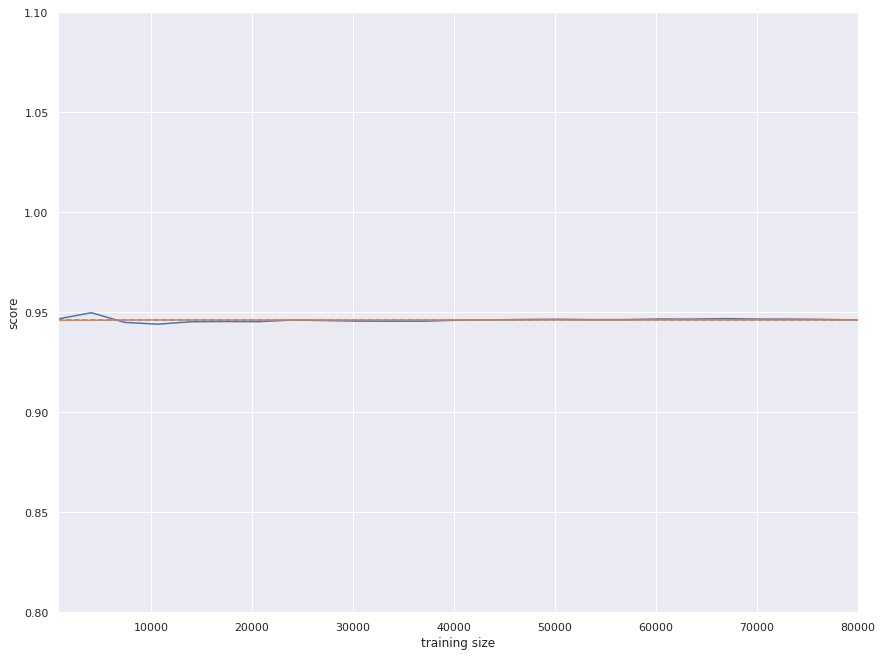

In [227]:
figsize = (800 / 72, 600 / 72)
figplacement = [0, 0, 1, 1 ]
    
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(figplacement)
ax.set_xlim(train_sizes_lr[0], train_sizes_lr[-1])
ax.set_ylim(0.8, 1.1)
ax.set_ylabel('score')
ax.set_xlabel('training size')

ax.plot(train_sizes_lr, np.mean(train_scores_lr, 1))
ax.plot(train_sizes_lr, np.mean(valid_scores_lr, 1))
ax.hlines(
    np.mean([train_scores_lr[-1], valid_scores_lr[-1]]), train_sizes_lr[0], train_sizes_lr[-1], 
    color='gray', linestyle='dashed'
)

# Sandbox

In [158]:
iter(clf_rf)

TypeError: 'Pipeline' object is not iterable

In [54]:
grid_search.best_estimator_.named_steps['classifier'].feature_importances_

array([0.21488511, 0.16278686, 0.15308707, 0.23668021, 0.01136321,
       0.0115617 , 0.00775483, 0.00749966, 0.00162614, 0.00172132,
       0.00184867, 0.00121644, 0.00165847, 0.00156642, 0.00188239,
       0.00162943, 0.00150145, 0.00167078, 0.00166597, 0.00163113,
       0.00148864, 0.00159195, 0.00171374, 0.00147427, 0.00157231,
       0.0015751 , 0.00166169, 0.00159031, 0.00164403, 0.0015754 ,
       0.00155372, 0.00163562, 0.00177216, 0.00155706, 0.00154994,
       0.00170553, 0.00166749, 0.00166762, 0.00165166, 0.00178198,
       0.00117346, 0.00151713, 0.00154522, 0.00199813, 0.00171574,
       0.0017868 , 0.00172737, 0.00169423, 0.00154478, 0.00116728,
       0.00174009, 0.0013667 , 0.00132052, 0.00159327, 0.00159598,
       0.00180388, 0.00140929, 0.00180862, 0.00122017, 0.00180897,
       0.00155924, 0.00157579, 0.00163189, 0.00159631, 0.00178493,
       0.00172729, 0.00176927, 0.00168934, 0.00175755, 0.00155772,
       0.00136073, 0.00166063, 0.00166687, 0.00173107, 0.00180

In [77]:
[x for x in grid_search.best_estimator_.get_params(deep=True) if 'preprocessor__cat__onehot' in x] # .named_steps  # ['preprocessor'].transformers[1][1].steps[1][1]

['preprocessor__cat__onehot',
 'preprocessor__cat__onehot__categorical_features',
 'preprocessor__cat__onehot__categories',
 'preprocessor__cat__onehot__dtype',
 'preprocessor__cat__onehot__handle_unknown',
 'preprocessor__cat__onehot__n_values',
 'preprocessor__cat__onehot__sparse']

In [94]:
grid_search.best_estimator_.named_steps['preprocessor'].transformers[1][1].named_steps['onehot'].get_feature_names()

# .get_params(deep=True)['preprocessor__cat__onehot'].get_feature_names()

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [56]:
X.columns

Index(['risk_score', 'gender', 'age', 'years_experience', 'role', 'company',
       'state', 'hours_worked_per_week'],
      dtype='object')

In [45]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='saga'))])

X = raw_data.drop('had_accident', axis=1)
y = raw_data['had_accident']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {
#     'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1, 10],
    'classifier__max_iter': [10, 100, 1000],
}

grid_search_lr = GridSearchCV(clf, param_grid, cv=10, iid=False)
grid_search_lr.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search_lr.score(X_test, y_test)))

best logistic regression from grid search: 0.946


In [47]:
print(("best logistic regression from grid search: %.3f"
       % grid_search_lr.score(X_test, y_test)))
print(("best random forest from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best logistic regression from grid search: 0.946
best random forest from grid search: 0.989


Featurize the data two ways. `f_data_a` encodes `role` and `gender` but leaves `state` and `company` as ordinal data. `f_data_b` encodes all the categorical fields.

In [3]:
f_data_a = pd.concat([raw_data, pd.get_dummies(raw_data['role'])], axis=1)
f_data_a = pd.concat([f_data_a, pd.get_dummies(f_data_a['gender'])], axis=1)
f_data_a = f_data_a[[x for x in f_data_a.columns if x not in ('gender', 'role')]]
f_data_a['had_accident'] = f_data_a['had_accident'].apply(lambda x: 1 if x else 0)

f_data_b = pd.concat([raw_data, pd.get_dummies(raw_data['role'])], axis=1)
f_data_b = pd.concat([f_data_b, pd.get_dummies(f_data_b['gender'])], axis=1)
f_data_b = pd.concat(
    [f_data_b, pd.get_dummies(f_data_b['state'].apply(lambda x: int(x)), prefix='state')],
    axis=1
)
f_data_b = pd.concat(
    [f_data_b, pd.get_dummies(f_data_b['company'].apply(lambda x: int(x)), prefix='company')], 
    axis=1
)
f_data_b = f_data_b[
    [x for x in f_data_b.columns if x not in ('gender', 'role', 'company', 'state')]
]
f_data_b['had_accident'] = f_data_b['had_accident'].apply(lambda x: 1 if x else 0)

Split the data into features and targets

In [5]:
X_a = f_data_a[[x for x in f_data_a.columns if x != 'had_accident']]
y_a = f_data_a['had_accident']

X_b = f_data_b[[x for x in f_data_b.columns if x != 'had_accident']]
y_b = f_data_b['had_accident']

Look at the variance of the features

Text(0, 0.5, 'cumulative explained variance')

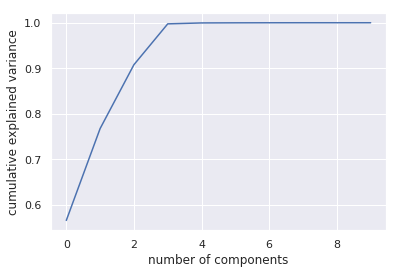

In [5]:
pca = PCA().fit(X_a)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0, 0.5, 'cumulative explained variance')

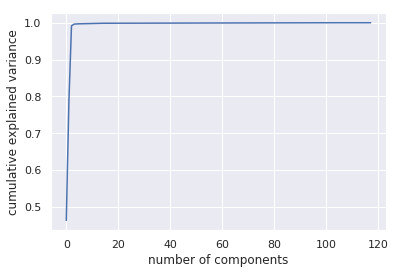

In [6]:
pca = PCA().fit(X_b)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Start modeling

In [6]:
lr_clf = LogisticRegression(solver='saga', max_iter=1000, warm_start=True)
scores_a = cross_val_score(lr_clf, X_a, y_a, cv=5)
scores_b = cross_val_score(lr_clf, X_b, y_b, cv=5)
print('A')
print('scores', scores_a)
print('mean', scores_a.mean())
print('std', scores_a.std())
print('B')
print('scores', scores_b)
print('mean', scores_b.mean())
print('std', scores_b.std())

A
scores [0.94615269 0.94615    0.94615    0.94615    0.94619731]
mean 0.9461600004461751
std 1.8683830366640557e-05
B
scores [0.94615269 0.94615    0.94615    0.94615    0.94619731]
mean 0.9461600004461751
std 1.8683830366640557e-05


In [7]:
for clf_class in all_classifiers:
    print(clf_class)
    clf = clf_class()
    scores = cross_val_score(clf, X_a, y_a, cv=5)
    print(scores)
    print()

<class 'sklearn.naive_bayes.GaussianNB'>
[0.94615269 0.94615    0.94615    0.94615    0.94619731]

<class 'sklearn.linear_model.logistic.LogisticRegression'>


/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/v

[0.94615269 0.94615    0.94615    0.94615    0.94619731]

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20

[0.94515274 0.9452     0.94515    0.945      0.94544727]



In [9]:
for clf_class in all_classifiers:
    print(clf_class)
    clf = clf_class()
    scores = cross_val_score(clf, X_b, y_b, cv=5)
    print(scores.mean())
    print()

<class 'sklearn.naive_bayes.GaussianNB'>
0.6289001361344253

<class 'sklearn.linear_model.logistic.LogisticRegression'>


/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/michaelsachs/.pyenv/v

0.9461600004461751

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/michaelsachs/.pyenv/versions/3.7.0/envs/glow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20

0.9450100044452251

